**Purpose of this Notebook**
This notebook describes three consecutive local-scaling steps improving the correspondence between the observed structure factor amplitude and the Wilson distributions. One can argue about whether such deviations reflect something true about a crystal form or not!

# Preprocessing of individual datasets
- takes 2-5 minutes total (up to n=4) or 10-15 min (with n=5)
- ironically, the main complication is for datasets which have been FW scaled--noisy reflections are overrepresented near the mean of the Wilson distributions and skew normalization. In the second step of anisotropic scaling I added weights to downweight the effects of noisy reflections.

In [32]:
# General tools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy   as np
import warnings
from mpl_toolkits    import mplot3d
from scipy.stats     import rice, foldnorm, nakagami, gamma 
from scipy.optimize  import least_squares, minimize
from time            import perf_counter

plt.rcParams.update({'font.size': 16})
t_overall_start = perf_counter()

In [33]:
import reciprocalspaceship as rs
import gemmi
from dw_tools import modify_ds, wilson, plots
from dw_tools import aniso_scaling_step_1 as aniso1
from dw_tools import aniso_scaling_step_2 as aniso2
from dw_tools import knn_tools as knn
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors       import KNeighborsRegressor
rs.__version__

'0.9.6'

In [34]:
%autosave 300
%load_ext autoreload
%autoreload 2

Autosaving every 300 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [39]:
# path="double_wilson_data\\" # Windows
# path="double_wilson_data/"    # Unix
path = "C:\\Users\\Doeke Hekstra\\Documents\\Lab_Hekstra\\Lab_projects\\Hekstra Doeke THz\\LQ92_EGFP_300fs\\"
data_set_pairs = [("5kvx_phases", "5kw3_phases"),\
                  ("5e1y_phases", "2vwr_phases"),\
                  ("3pyp_phases", "1nwz_phases"),\
                  ("1otb_phases", "1nwz_phases"),\
                  ("4eul_phases", "GFP_1.37A"),\
#                   "GFP_SSRL_refine_54_final"),\
                  ("4eul_phases", "2y0g_phases"),\
                  ("4kjk_phases", "4kjj_phases", "4pst_phases", "4pss_phases"),\
                  ("e35cdef_OFF200ns_HD_2sig_varEll","e35cdef_200ns_HD_2sig_varEll"),\
                 ("on","off"),\
                 ("off", "4EUL_phases","GFP_SSRL_refine_54_final", "EGFP_phases_w_FOM_SSRL")]                # 9
# example 1 fails on kNN regression
example=9
dataset=3
mtz1 = data_set_pairs[example][dataset] # omit .mtz
ds1 = rs.read_mtz(path + mtz1 + ".mtz")

# cleanup:
unpurged_count = ds1.shape[0];   ds1.dropna(inplace=True)
purged_count   = ds1.shape[0]
print(f"Discarded {unpurged_count-purged_count} out of {unpurged_count} records")

Discarded 0 out of 93887 records


In [40]:
ds1.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 93887 entries, (0, 0, 2) to (37, 8, -2)
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype             
---  ------         --------------  -----             
 0   FOBS           93887 non-null  SFAmplitude       
 1   SIGFOBS        93887 non-null  Stddev            
 2   R_FREE_FLAGS   93887 non-null  MTZInt            
 3   FMODEL         93887 non-null  SFAmplitude       
 4   PHIFMODEL      93887 non-null  Phase             
 5   FCALC          93887 non-null  SFAmplitude       
 6   PHIFCALC       93887 non-null  Phase             
 7   FMASK          93887 non-null  SFAmplitude       
 8   PHIFMASK       93887 non-null  Phase             
 9   K_ISOTROPIC    93887 non-null  SFAmplitude       
 10  K_ANISOTROPIC  93887 non-null  SFAmplitude       
 11  K_MASK         93887 non-null  SFAmplitude       
 12  SIGK_MASK      93887 non-null  Stddev            
 13  FOM            93887 non-null  SFAmplit

The following two cells do some dataset specific manipulations to convert from intensities to structure factor amplitudes. All _ad hoc_.

In [48]:
if (example == 4) & (dataset==1): # - GFP_1.37A only contains intensities
    I = ds1["IMEAN"].to_numpy()
    SIGI = ds1["SIGIMEAN"].to_numpy()
    I[I<=0]=0.0001
    ds1["FP"] = np.sqrt(I)
    ds1["SIGFP"] = 0.5*np.sqrt(SIGI**2/I) #I played with using the Nakagami distribution instead, but it seems that its
                                          # std calculation is not very stable
                                          # so using naive error propagation instead.
# if (example == 4) & (dataset==1):
#     ds1["FP"] = ds1["F-obs-filtered"]
#     ds1["SIGFP"] = ds1["SIGF-obs-filtered"]

if (example == 9) & (dataset==2):
    ds1["FP"] = ds1["F-obs-filtered"]
    ds1["SIGFP"] = ds1["SIGF-obs-filtered"]
if (example == 9) & (dataset==3):
    ds1["FP"] = ds1["FMODEL"]
    ds1.spacegroup = gemmi.SpaceGroup("P 21 1 1")

if (example == 8):
    ds1["FP"] = ds1["F"]
    ds1["SIGFP"] = ds1["SigF"]

In [7]:
# modify_ds.merge_anomalous(ds1)
# ds1.loc[ds1["I(+)"]>ds1["I(-)"],["I(+)","SIGI(+)","I(-)","SIGI(-)","IMEAN","SIGIMEAN","I","SIGI"]]

In [49]:
# ds1.info()
print(ds1.spacegroup)

<gemmi.SpaceGroup("P 21 1 1")>


Let's inspect $\left< F \right>$ by resolution bin.

Average observations per bin: 4694.35


(0.0, 504.29678535461426)

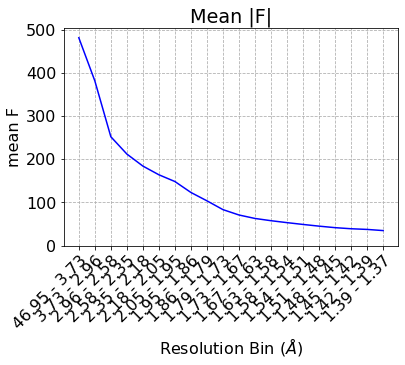

In [50]:
result, bin_labels = plots.compute_meanF_byres(ds1, label="FP", nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result, bin_labels, ylabel="mean F",color='b')
plt.title("Mean |F|")
plt.ylim(0,)

Some very basic scaling:

In [56]:
avg = ds1["FP"].mean()
ds1["FP"] = ds1["FP"]/avg
ds1["SIGFP"] = 1

Let's add reciprocal lattice point coordinates, ```dHKL```, (a)centric labels, and multiplicities!

In [57]:
modify_ds.ds_add_rs(ds1)
ds1.compute_dHKL(        inplace=True)
ds1.label_centrics(      inplace=True)
ds1.compute_multiplicity(inplace=True);

### Checking reciprocal space (ASU) coverage
Let's see what chunk of reciprocal space these reflections are located in. 

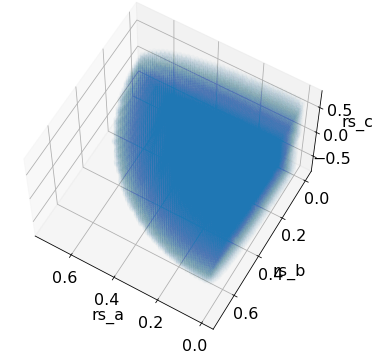

In [58]:
plt.ion
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection="3d")
ax.scatter3D(ds1["rs_a"], ds1["rs_b"], ds1["rs_c"],alpha=0.01)
ax.view_init(elev=60., azim=1200.)
ax.set_xlabel("rs_a")
ax.set_ylabel("rs_b")
ax.set_zlabel("rs_c")
plt.draw()

## Simple anisotropic normalization

First, we fit an anisotropic $B$ factor scaling model to the data using the Wilson distribution as the loss function. This provides our first version of normalized structure factors.

In [60]:
# print(np.amin(ds1["FP"].to_numpy()))
# print(np.amax(ds1["FP"].to_numpy()))
# print(np.sum(np.isnan(ds1["FP"].to_numpy())))
res = minimize(         aniso1.anisotropic_scaling_to_1_wilson_loss, [0,0,0,0,0,0,1],\
                                                                method='L-BFGS-B',jac=True,args=(ds1,"FP"))
res_test, ep1, sigep1 = aniso1.anisotropic_scaling_to_1_wilson_loss(res.x, ds1, label="FP", nargout=3)
print(res.x)

ds1["EP_1_aniso_1"] = ep1
ds1["SIGEP_1_aniso_1"] = sigep1
ds1_unfiltered = ds1
ds1_unfiltered.info()

[-5.72591768e+00  2.79598540e-01 -5.11179665e-03 -5.39160237e+00
 -6.24319122e-03 -6.36386401e+00  1.98075371e-01]
<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 93887 entries, (0, 0, 2) to (37, 8, -2)
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype             
---  ------           --------------  -----             
 0   FOBS             93887 non-null  SFAmplitude       
 1   SIGFOBS          93887 non-null  Stddev            
 2   R_FREE_FLAGS     93887 non-null  MTZInt            
 3   FMODEL           93887 non-null  SFAmplitude       
 4   PHIFMODEL        93887 non-null  Phase             
 5   FCALC            93887 non-null  SFAmplitude       
 6   PHIFCALC         93887 non-null  Phase             
 7   FMASK            93887 non-null  SFAmplitude       
 8   PHIFMASK         93887 non-null  Phase             
 9   K_ISOTROPIC      93887 non-null  SFAmplitude       
 10  K_ANISOTROPIC    93887 non-null  SFAmplitude       
 11  K_MASK  

In [14]:
# there are a few really large values which we'll discard so they don't warp 
if (example == 8):
    tmp=(ep1 < np.percentile(ep1,99.99)) & (sigep1<0.4)
    ds1 = ds1[tmp]
    ep1 = ep1[tmp]
    sigep1 = sigep1[tmp]
    ds1.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 21137 entries, (0, 0, 4) to (29, 9, 6)
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype      
---  ------           --------------  -----      
 0   F                21137 non-null  SFAmplitude
 1   SigF             21137 non-null  Stddev     
 2   I                21137 non-null  Intensity  
 3   SigI             21137 non-null  Stddev     
 4   FP               21137 non-null  SFAmplitude
 5   SIGFP            21137 non-null  Stddev     
 6   rs_a             21137 non-null  float64    
 7   rs_b             21137 non-null  float64    
 8   rs_c             21137 non-null  float64    
 9   dHKL             21137 non-null  MTZReal    
 10  CENTRIC          21137 non-null  bool       
 11  EPSILON          21137 non-null  MTZInt     
 12  EP_1_aniso_1     21137 non-null  float64    
 13  SIGEP_1_aniso_1  21137 non-null  float64    
dtypes: Intensity(1), MTZInt(1), MTZReal(1), SFAmplitude(2), Stddev(3)

### Inspection of histograms. 
In the absence of a sigma cutoff, we often get significant extra counts around the mode of the distribution. This must be the consequence of FW scaling. When we omit these, we see that the histogram is a bit shifted relative the Wilson distribution, suggesting noisy reflections skewed normalization.

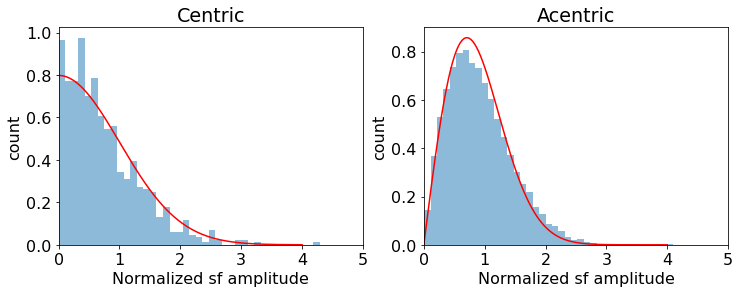

In [61]:
sig_cut = 0.5 # noisy observations deviation significantly from the Wilson distribution!
              # ironically, French-Wilson seems to blame--the reflections with largest error 
              # will tend to get scaled to the mean of the Wilson distribution

x=np.linspace(0,4,500)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(ep1[(ds1["CENTRIC"]==True) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x,wilson.wilson_dist_normalized(x,centric=True),'r-') 
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5])
plt.title("Centric")

plt.subplot(1,2,2)
plt.hist(ep1[(ds1["CENTRIC"]==False) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x,centric=False),'r-')
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5])
plt.title("Acentric"); 

## Anisotropic normalization with Fourier corrections

In this section, we calculate a pattern of correction coefficients in reciprocal space that improves upon the above anisotropic scaling corrections. We do so using a Fourier series. That is, 

$$
C_{hkl} = A_0 + \sum_{m,n,p} A_{mnp} \cos(2\pi h^T m/L) + B_{mnp} \sin(2\pi h^T m/L)
$$

with $h=(h,k,l)$ the Miller indices and $m=(m,n,p)$ the 3D Fourier component indices. We test the optimal order of the Fourier series by cross validation (the upper limit for $m,n,p$).

In [62]:
rseed=1763
np.random.seed(rseed)
ds1["test_flag"] = (np.random.random((ds1.shape[0],1)) <0.85)

In [65]:
# typically the minimum is for n=3 or 4...
# see right below for typical run times by n (n=4: 2-3 min total)
# note that at higher values of n sometimes NaNs pop up

res=[0] # start with a dummy so next entries match their n
n_best = 0
best_loss = 9e9
for n in [1,2]:
    t1_start = perf_counter()
    params = aniso2.prepare_for_FFT(ds1, n=n, label="EP_1_aniso_1")
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        init_guess = np.zeros((1,2*(n**3)))
        if n>1:
            init_guess[0,:res[-1].x.shape[0]]=res[-1].x
        else:
            init_guess[0]=np.array([1, 0])
        res_tmp = minimize(aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast, \
                           init_guess,method='L-BFGS-B', jac = True, \
                           args=(params,ds1["test_flag"].to_numpy()))
        res.append(res_tmp)
        res_test = aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast(res_tmp.x, \
                                          params, bUse=~ds1["test_flag"].to_numpy(), nargout=1)
        if res_test[0] < best_loss:
            best_loss = res_test[0]
            n_best = n
        print(f"For n = {n} the test loss = {res_test[0]:.6}")
        t1_stop = perf_counter()  
        print(f"Elapsed time: {t1_stop-t1_start:.4} s")

For n = 1 the test loss = 1303.67
Elapsed time: 3.191 s
For n = 2 the test loss = 1284.38
Elapsed time: 16.58 s


In [66]:
# run for best n using *all* reflections and save
params = aniso2.prepare_for_FFT(ds1, n=n_best, label="EP_1_aniso_1")

loss, ep1, sigep1, scale1 = aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast(res[n_best].x, params, \
                                                        bUse=np.ones((ds1.shape[0],),dtype=bool), nargout=3)

EP1_label = "EP_1_aniso_2"
ds1[EP1_label]   = ep1
ds1["SIG" + EP1_label]= sigep1
print(np.mean(ep1[ds1["CENTRIC"]==True]**2))
print(np.mean(ep1[ds1["CENTRIC"]==False]**2))

1.0404498715097823
1.0693793389175466


Graphical inspection:

C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


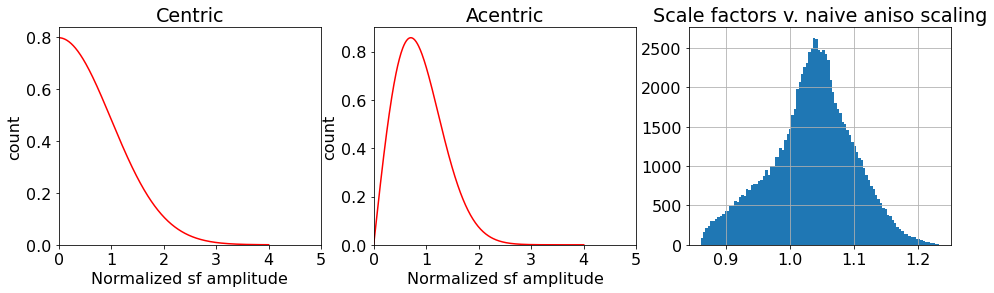

IndexError: cannot do a non-empty take from an empty axes.

In [67]:
sig_cut = 0.1 # noisy observations deviation significantly from the Wilson distribution!
              # ironically, French-Wilson scaling seems to blame.

x=np.linspace(0,4,500)
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.hist(ep1[(ds1["CENTRIC"]==True) & (sigep1<sig_cut)],20,alpha=0.5,density=True)
plt.plot(x,wilson.wilson_dist_normalized(x,centric=True),'r-') 
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5]); plt.title("Centric")

plt.subplot(1,3,2)
plt.hist(ep1[(ds1["CENTRIC"]==False) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x,centric=False),'r-')
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5]); plt.title("Acentric"); 

plt.subplot(1,3,3)
plt.hist(scale1,100); plt.grid()
plt.title("Scale factors v. naive aniso scaling")
plt.show()

print(np.percentile(ep1[(ds1["CENTRIC"]==True) & (sigep1<sig_cut)],99.95))
print(np.percentile(ep1[(ds1["CENTRIC"]==False) & (sigep1<sig_cut)],99.95))

## Normalization by regression estimates of Sigma
We will now estimate $<|F|^2>$ locally in reciprocal space, starting from the Fourier-corrected anomalous estimates above. Because the expected intensity is the same for acentric and centric reflections, we can do this in one go for all of them.

By Rupp eq. (7-104): $ \Sigma_N = \left<I\right>/\varepsilon_h $

Below are two implementations of $\Sigma$ estimation: using kernel ridge regression and k-nearest neighbors with custom weights. The former retains more of the correlation among data sets than the latter, but is **much** slower and more memory-intensive. It crashes on the cluster.

In [68]:
temp = ds1["EPSILON"][ds1["CENTRIC"].to_numpy()==True]
print("Distribution of multiplicities for centric reflections:")
print(temp.value_counts())
print("")

temp = ds1["EPSILON"][ds1["CENTRIC"].to_numpy()==False]
print("Distribution of multiplicities for acentric reflections:")
print(temp.value_counts())

Distribution of multiplicities for centric reflections:
1    2692
Name: EPSILON, dtype: int64

Distribution of multiplicities for acentric reflections:
1    91178
2       17
Name: EPSILON, dtype: int64


We now perform k-nearest neighbor regression (with self excluded). The optimal $k$ (and uniform weights) are **much higher** when the input have already been anisotropically scaled. Larger $k$ is also slower...

In [69]:
##### TEMPORARY -- REMOVE FOR ANYTHING BUT FMODEL ######
EP1_label = "EP_1_aniso_1"

In [70]:
gridsearch = False 
ncpu=2 #8 worked on the cluster
param_grid={"n_neighbors":[50,100,200,400,800],'weights':['uniform',knn.knn_weight_exp_p05, knn.knn_weight_norm_p05]}
#                                                                   knn.knn_weight_exp_p02, knn.knn_weight_norm_p02, \
#                                                                   knn.knn_weight_exp_p03, knn.knn_weight_norm_p03]}
if gridsearch: 
    knn_1 = GridSearchCV(KNeighborsRegressor(n_jobs=ncpu),param_grid=param_grid)
    knn_1.fit(ds1[["rs_a", "rs_b", "rs_c"]].to_numpy(), (ds1[EP1_label].to_numpy()**2)) # these should be corrected for eps already
else:
    knn_1 = KNeighborsRegressor(800, weights=knn.knn_weight_exp_p05,n_jobs=ncpu)
    knn_1.fit(ds1[["rs_a", "rs_b", "rs_c"]], (ds1[[EP1_label]].to_numpy()**2))

if gridsearch:
    print(knn_1.best_params_)

In [71]:
Sigma_1 = knn_1.predict(ds1[["rs_a", "rs_b", "rs_c"]]).reshape(-1,1)

In [72]:
E1    = ds1[        EP1_label].to_numpy().reshape(-1,1)/np.sqrt(Sigma_1) # We've already taken care of epsilon above
SIGE1 = ds1["SIG" + EP1_label].to_numpy().reshape(-1,1)/np.sqrt(Sigma_1)

ds1["EP_1_knn"]    = E1
ds1["SIGEP_1_knn"] = SIGE1

## Analysis

Average observations per bin: 4694.35
Average observations per bin: 4694.35
Average observations per bin: 4694.35
Average observations per bin: 4694.35


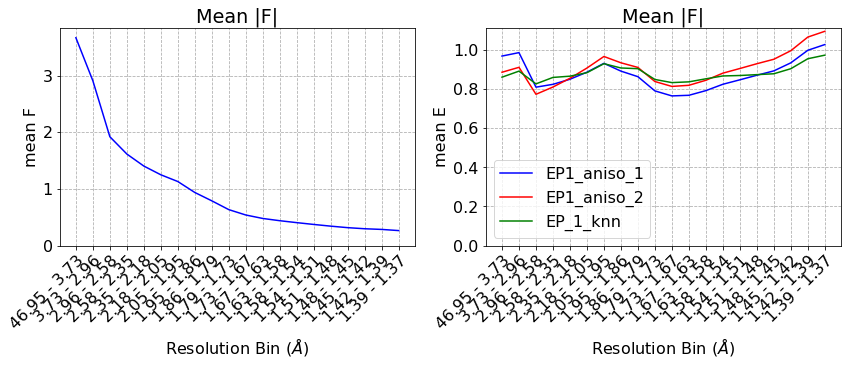

In [73]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
result, bin_labels = plots.compute_meanF_byres(ds1, label="FP", nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result, bin_labels, ylabel="mean F",color='b')
plt.title("Mean |F|")
plt.ylim(0,)

plt.subplot(1,2,2)
result_1, bin_labels_1 = plots.compute_meanF_byres(ds1, label="EP_1_aniso_1", nbins=20,sigma_cut=0)
result_2, bin_labels_2 = plots.compute_meanF_byres(ds1, label="EP_1_aniso_2", nbins=20,sigma_cut=0)
result_3, bin_labels_3 = plots.compute_meanF_byres(ds1, label="EP_1_knn",     nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result_1, bin_labels_1, ylabel="mean E",color='b')
plots.plot_by_res_bin(result_2, bin_labels_2, ylabel="mean E",color='r')
plots.plot_by_res_bin(result_3, bin_labels_2, ylabel="mean E",color='g')
plt.title("Mean |F|")
plt.legend(["EP1_aniso_1", "EP1_aniso_2","EP_1_knn"])
plt.ylim(0,)
plt.show()

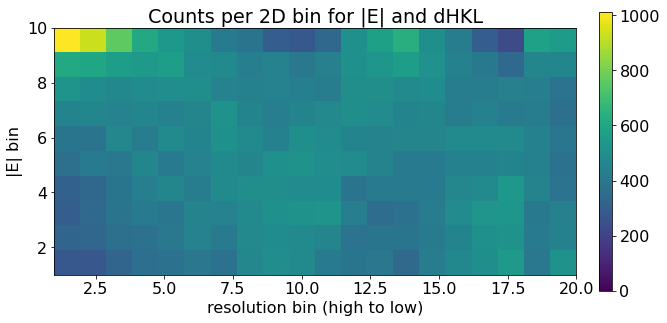

In [74]:
# Let's examine the distribution of dHKL and E in the data
sig_cut = 10
nbin    = (20,10)

cdf_bins     = np.linspace(0,100,nbin[0]+1)
d_bins       = np.percentile(ds1["dHKL"], cdf_bins)
d_bins[-1]   = d_bins[-1]+1e-6   # to avoid omitting the largest data point
d_dig        = np.digitize(ds1["dHKL"], d_bins)
ds1["dHKL_bin"] = d_dig.flatten()
# print(d_bins)

cdf_bins     = np.linspace(0,100,nbin[1]+1)
ep1_bins     = np.percentile(ds1[EP1_label], cdf_bins)
ep1_bins[-1] = ep1_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_dig      = np.digitize(ds1["EP_1_aniso_2"], ep1_bins)
ds1["EP_1_bin"] = ep1_dig.flatten()

H, xedges, yedges = np.histogram2d(ds1.loc[(ds1["CENTRIC"]==False) & (ds1["SIG" + EP1_label]<sig_cut), "dHKL_bin"], \
                                   ds1.loc[(ds1["CENTRIC"]==False) & (ds1["SIG" + EP1_label]<sig_cut), "EP_1_bin"],bins=nbin)

plt.figure(figsize=(10,8))
im=plt.imshow(H.transpose(), interpolation='nearest', origin='lower',\
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0)
plt.xlabel("resolution bin (high to low)")
plt.ylabel("|E| bin")
plt.title("Counts per 2D bin for |E| and dHKL")
plt.colorbar(im,fraction=0.025, pad=0.04)

fname = mtz1 + "_n" + str(n_best) + "_" + EP1_label + "_" + str(rseed)+ ".png"
plt.savefig("results_figs/" + fname)
plt.show()

## Cleaning up 

In [75]:
# ds1["FP"]             = ds1["FP"             ].astype("SFAmplitude")
# ds1["SIGFP"]          = ds1["FP"             ].astype("Stddev")
ds1["rs_a"]           = ds1["rs_a"           ].astype("MTZReal")
ds1["rs_b"]           = ds1["rs_b"           ].astype("MTZReal")
ds1["rs_c"]           = ds1["rs_c"           ].astype("MTZReal")
ds1["EP_1_aniso_1"]   = ds1["EP_1_aniso_1"   ].astype("NormalizedSFAmplitude")
ds1["EP_1_aniso_2"]   = ds1["EP_1_aniso_2"   ].astype("NormalizedSFAmplitude")
ds1["EP_1_knn"]       = ds1["EP_1_knn"       ].astype("NormalizedSFAmplitude")
ds1["SIGEP_1_aniso_1"]= ds1["SIGEP_1_aniso_1"].astype("Stddev")
ds1["SIGEP_1_aniso_2"]= ds1["SIGEP_1_aniso_2"].astype("Stddev")
ds1["SIGEP_1_knn"]    = ds1["SIGEP_1_knn"    ].astype("Stddev")
# ds1.info()

Let's check whether we still have unsupported column datatypes around!

In [76]:
modify_ds.check_col_dtypes(ds1)

Column "CENTRIC" has a datatype not supported by the MTZ format.
Column "SIGFP" has a datatype not supported by the MTZ format.
Column "test_flag" has a datatype not supported by the MTZ format.
Column "dHKL_bin" has a datatype not supported by the MTZ format.
Column "EP_1_bin" has a datatype not supported by the MTZ format.


In [77]:
# We'll have to add centric flags back later
ds1.write_mtz(path + mtz1 + "_use_aniso_1_only.mtz",skip_problem_mtztypes=True)
t_overall_end = perf_counter()
print("Total elapsed time:", t_overall_end-t_overall_start)

Total elapsed time: 1222.3580041000005


## Obsolete stuff

4.49978242925093


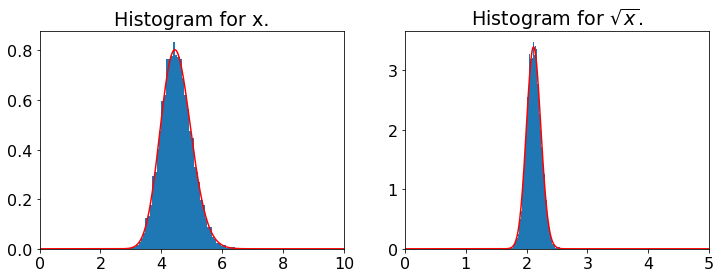

In [29]:
mu = 4.5
var = 0.5**2
theta = var/mu
k = mu/theta
m = k
Om = m*theta
std = nakagami.std(m, loc=0, scale=np.sqrt(Om))
x = gamma.rvs(a=k, scale=theta, size=10000)
base=np.linspace(0,12,1000)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(x,50,density=True)
plt.plot(base, gamma.pdf(x=base, a=k, scale=theta),'r-')
plt.title(r"Histogram for x."); plt.xlim([0,10])

plt.subplot(1,2,2)
plt.hist(np.sqrt(x),50,density=True)
print(np.mean(x))
plt.plot(base, nakagami.pdf(x=base, nu=k, scale=np.sqrt(Om)),'r-')
plt.title(r"Histogram for $\sqrt{x}$."); plt.xlim([0,5])
plt.show()